In [71]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

%matplotlib inline



[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/crystal/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [56]:
sent4 = "The Lumberjack Song is the funniest Monty Python bit: I can't think of it without laughing."
sent5 = "I would rather put strawberries on my ice cream for dessert, they have the best taste."
sent6 = "The taste of caramel is a fantastic accompaniment to tasty mint ice cream."


Generate vecotrs for sent4, sent5, sent6<br>
Word   df   cf  idf     sent4   sent5 sent6<br>
Monty	2	2	1.585    1.585   0      0<br>
Python	3	3	1        1       0      0<br>
sketch	2	2	1.585    0       0      0<br>
laugh	3	3	1        1       0      0<br>
funny	2	4	1.585    1.585   0      0<br>
best	4	4	.585     0       .585   0<br>
ice cream	3	3	1    0       1      1<br>
dessert	2	2	1.585    0       1.585  0<br>
taste	3	4	1        0       1      2<br>


In [57]:
# reading in the data, this time in paragraphs
emma = gutenberg.paras('austen-emma.txt')
# processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    # removing teh double dash from all words
    para=[re.sub(r'--','', word) for word in para]
    # Forming each paragraph into a string and adding it to the list
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [58]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half
                             min_df=2, # words appear at least 2x
                             stop_words='english',
                             lowercase=True, # convert everything to lowercase
                             use_idf=True, # use inverse document frequencies
                             norm=u'l2', # applies correction factor for different length paragraphs
                             smooth_idf=True # Adds 1 to all doc frequencies, prevents divide by 0
                            )

# Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print('Number of features: {}'.format(emma_paras_tfidf.get_shape()[1]))

# split in to training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs
n = X_train_tfidf_csr.shape[0]
# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0, n)]
# List of features
terms = vectorizer.get_feature_names()
# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
# Keep in mind that the log base 2 of 1 is 0, so tf-idf score
# of 0 indicates the word was present once in the sentence
print('Original Sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original Sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


# Dimension reduction
- Use Singular Value Decomposition (SVD) from sklearn rather than PCA because we don't want to mean center our variables (and thus lose sparsity)

In [59]:
# Our SVD data reducer
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)
# Looking at what sorts of paragraphs our solution considers similar, 
# for the first 5 identified topics
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:, i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.2158698544375
Component 0:
" Oh !"    0.999285
" Oh !     0.999285
" Oh !     0.999285
" Oh !     0.999285
" Oh !"    0.999285
" Oh !     0.999285
" Oh !     0.999285
" Oh !     0.999285
" Oh !     0.999285
" Oh !     0.999285
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633882
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.587132
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.565617
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton

# Sentence similarity
- Look at how similar sentences are to one another


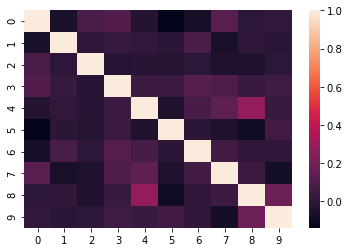

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [60]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
# Only taking the first 10 sentences
sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10, 0:10]
# Making a plot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

# Generating a key for the plot
print('Key:')
for i in range(10):
    print(i, sim_matrix.index[i])

# Drill 0: Test Set
Apply LSA model to the test set.  Does it identify similar sentences for components 0-4?

In [61]:
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)
# Looking at what sorts of paragraphs our solution considers similar, 
# for the first 5 identified topics
paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:, i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.2158698544375
Component 0:
" Oh !    0.999285
" Oh !    0.999285
" Oh !    0.999285
" Oh !    0.999285
" Oh !    0.999285
" Oh !    0.999285
" Oh !    0.999285
" Oh !    0.999285
" Oh !    0.999285
" Oh !    0.999285
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                                                          0.675319
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbation of  and it then appeared that Mrs . We

# Drill 1: Tweaking tf-idf
Go back up to the code where we originally translated the text from words to numbers. There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well. We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities. Change things up a few times and see how that affects the results of the LSA. Write up your observations and share them with your mentor.

In [62]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half
                             min_df=5, # words appear at least 2x
                             stop_words='english',
                             lowercase=True, # convert everything to lowercase
                             use_idf=True, # use inverse document frequencies
                             norm=u'l2', # applies correction factor for different length paragraphs
                             smooth_idf=True # Adds 1 to all doc frequencies, prevents divide by 0
                            )

# Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print('Number of features: {}'.format(emma_paras_tfidf.get_shape()[1]))

# split in to training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs
n = X_train_tfidf_csr.shape[0]
# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0, n)]
# List of features
terms = vectorizer.get_feature_names()
# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
# Keep in mind that the log base 2 of 1 is 0, so tf-idf score
# of 0 indicates the word was present once in the sentence
print('Original Sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 799
Original Sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


Changing the min_df has more of an effect on this dataset than the max_df.  

In [63]:
# Our SVD data reducer
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)
# Looking at what sorts of paragraphs our solution considers similar, 
# for the first 5 identified topics
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:, i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 55.88566090013395
Component 0:
" Oh !     0.999073
" Oh !     0.999073
" Oh !"    0.999073
" Oh !     0.999073
" Oh !     0.999073
" Oh !     0.999073
" Oh !     0.999073
" Oh !     0.999073
" Oh !     0.999073
" Oh !     0.999073
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.708593
Mr . Knightley might quarrel with her , but Emma could not quarrel with herself .                                                                                           0.616191
" There were misunderstandings between them , Emma ; he said so expressly .                                                                                                 0.608763
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                         

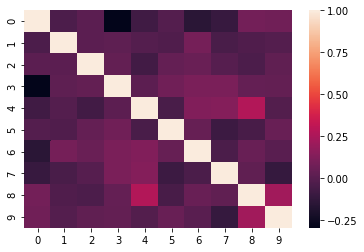

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [64]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
# Only taking the first 10 sentences
sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10, 0:10]
# Making a plot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

# Generating a key for the plot
print('Key:')
for i in range(10):
    print(i, sim_matrix.index[i])

In [65]:
paras_by_component

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
That is _court_ .,2.281133e-01,-4.487332e-01,-1.089502e-01,8.503814e-03,-7.853720e-02,1.843503e-02,-6.740448e-03,-6.049715e-02,-3.221554e-02,3.114161e-02,...,-8.731199e-03,-1.560661e-01,1.119759e-02,1.475121e-01,-2.665692e-02,7.970298e-02,-3.454866e-03,1.146073e-01,3.292281e-02,-7.565523e-02
""" Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me .""",1.705331e-02,1.125494e-01,-6.295960e-09,-4.247947e-03,-7.421905e-02,4.773695e-02,-2.086563e-03,-9.557431e-02,4.005553e-02,5.175918e-02,...,-9.898883e-04,-5.412825e-02,3.018653e-02,-1.452074e-02,-2.913191e-02,-3.166890e-02,1.521153e-02,1.734620e-02,-6.424573e-02,2.345601e-02
""" How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .",4.062225e-04,3.088658e-02,1.665397e-07,-1.127420e-02,-1.775536e-02,3.108481e-03,1.125515e-02,-1.426176e-02,-1.536013e-02,2.989094e-03,...,-3.607077e-03,3.219303e-02,1.073234e-01,-1.022469e-02,1.915822e-02,1.261253e-02,5.248203e-02,-1.160312e-01,5.766840e-02,6.264247e-02
"To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up her hand seized her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping fearing adoring ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being seriously accepted as soon as possible .",6.140491e-03,1.907083e-01,2.621171e-07,-1.361821e-01,6.859676e-02,-4.194826e-02,1.110067e-02,-7.368682e-02,3.852109e-02,-1.895826e-04,...,5.119613e-02,-3.118342e-02,1.259566e-01,-2.146365e-01,6.096286e-02,-3.833146e-02,-2.215785e-02,-7.245803e-02,1.088748e-01,-2.642860e-02
"Emma smiled and answered "" My visit was of use to the nervous part of her complaint , I hope ; but not even I can charm away a sore throat ; it is a most severe cold indeed .",2.782580e-03,1.962269e-01,2.669774e-07,1.670446e-01,1.664018e-02,-9.870591e-02,-1.184558e-03,7.392572e-03,2.818073e-02,8.071458e-03,...,-1.705885e-02,1.308360e-02,-4.695006e-02,-8.552671e-02,-3.243873e-03,-2.385894e-04,-1.438393e-01,1.645613e-03,-1.310227e-02,-1.731183e-01
"A very few minutes more , however , completed the present trial .",2.704127e-03,4.122461e-02,-1.315845e-08,-4.787729e-03,-2.227626e-02,-2.762869e-03,1.139526e-03,-3.768723e-02,8.498922e-03,-1.961209e-02,...,-2.211100e-01,2.048914e-01,6.711814e-02,6.452944e-02,-1.088307e-01,-1.604783e-02,1.117395e-01,-1.061376e-01,7.204406e-02,1.682225e-01
""" I am delighted to hear you speak so stoutly on the subject ,"" replied Emma , smiling ; "" but you do not mean to deny that there was a time and not very distant either when you gave me reason to understand that you did care about him ?""",5.581183e-03,2.193381e-01,-2.060908e-07,9.709208e-02,-3.212081e-03,-9.227531e-02,2.404576e-04,-5.252767e-02,7.542131e-02,3.588037e-02,...,-3.175077e-02,1.478152e-02,-4.766812e-02,-3.603949e-02,9.061679e-04,1.258518e-01,5.424293e-02,2.216863e-02,-1.455996e-02,-6.888757e-02
""" Very well ; and if he had intended to give her one , he would have told her so .""",4.693211e-04,2.709087e-02,4.808718e-08,6.361013e-03,-1.251554e-02,2.253711e-02,-2.217782e-03,-1.594498e-02,1.889424e-02,1.455412e-02,...,1.354639e-01,-7.858767e-02,3.183454e-01,-3.512728e-02,-2.531908e-01,-1.355198e-01,-3.773518e-01,1.109382e-01,1.769387e-01,4.208802e-02
"Some laughed , and answered good - humouredly .",2.411899e-03,6.023383e-02,4.986738e-08,1.351058e-02,-1.502113e-02,2.583356e-02,-2.9933

# Add n-grams

In [66]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half
                             min_df=5, # words appear at least 2x
                             stop_words='english',
                             lowercase=True, # convert everything to lowercase
                             use_idf=True, # use inverse document frequencies
                             norm=u'l2', # applies correction factor for different length paragraphs
                             smooth_idf=True, # Adds 1 to all doc frequencies, prevents divide by 0
                             ngram_range=(1, 3) # phrase lengths to consider
                            )

# Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print('Number of features: {}'.format(emma_paras_tfidf.get_shape()[1]))

# split in to training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs
n = X_train_tfidf_csr.shape[0]
# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0, n)]
# List of features
terms = vectorizer.get_feature_names()
# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
# Keep in mind that the log base 2 of 1 is 0, so tf-idf score
# of 0 indicates the word was present once in the sentence
print('Original Sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 889
Original Sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [67]:
# Our SVD data reducer
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)
# Looking at what sorts of paragraphs our solution considers similar, 
# for the first 5 identified topics
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:, i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 54.83455837815121
Component 0:
" Oh !     0.999374
" Oh !"    0.999374
" Oh !     0.999374
" Oh !     0.999374
" Oh !     0.999374
" Oh !     0.999374
" Oh !"    0.999374
" Oh !     0.999374
" Oh !     0.999374
" Oh !     0.999374
Name: 0, dtype: float64
Component 1:
CHAPTER I       1.0
CHAPTER VIII    1.0
CHAPTER XIII    1.0
CHAPTER II      1.0
CHAPTER X       1.0
CHAPTER XVI     1.0
CHAPTER IX      1.0
CHAPTER II      1.0
CHAPTER XI      1.0
CHAPTER XVI     1.0
Name: 1, dtype: float64
Component 2:
Mr . Knightley might quarrel with her , but Emma could not quarrel with herself .                                                                                                                                                                                                                                                                                                                                                                                 

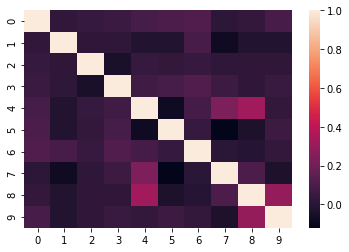

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [68]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
# Only taking the first 10 sentences
sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10, 0:10]
# Making a plot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

# Generating a key for the plot
print('Key:')
for i in range(10):
    print(i, sim_matrix.index[i])

In [69]:
terms

['_i_',
 '_you_',
 'abbey',
 'able',
 'absolutely',
 'accomplished',
 'account',
 'acquaintance',
 'acquainted',
 'actually',
 'added',
 'addressing',
 'admiration',
 'advantage',
 'advantages',
 'advice',
 'affection',
 'afraid',
 'age',
 'agitated',
 'agitation',
 'ago',
 'agree',
 'agreeable',
 'agreed',
 'ah',
 'air',
 'alarm',
 'allow',
 'allowed',
 'aloud',
 'amiable',
 'amused',
 'amusement',
 'angry',
 'answer',
 'answered',
 'anxiety',
 'anxious',
 'appear',
 'appearance',
 'appeared',
 'appears',
 'approbation',
 'arm',
 'arrangement',
 'arrival',
 'arrived',
 'ashamed',
 'ask',
 'asked',
 'assure',
 'assured',
 'attached',
 'attachment',
 'attended',
 'attention',
 'attentions',
 'aunt',
 'aware',
 'away',
 'aye',
 'bad',
 'ball',
 'bates',
 'bath',
 'bear',
 'beautiful',
 'beauty',
 'began',
 'begin',
 'beginning',
 'behaviour',
 'believe',
 'believed',
 'belong',
 'best',
 'better',
 'blush',
 'body',
 'book',
 'box',
 'box hill',
 'boy',
 'bring',
 'brother',
 'brought',


# Add lemmas

In [85]:
nlp = spacy.load('en_core_web_sm')

# reading in the data, this time in paragraphs
emma = gutenberg.raw('austen-emma.txt')

# Utility function for standard text cleaning
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'. 
    text = re.sub(r'--',' ',text)
    # get rid of text between brackets
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

emma = text_cleaner(emma)

emma_doc = nlp(emma)


In [93]:
emma_sents = [' '.join([token.lemma_ for token in sent]) for sent in emma_doc.sents]


In [94]:
emma_sents[0:5]

['volume -PRON- chapter',
 '-PRON-',
 'emma woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seem to unite some of the good blessing of existence ; and have live nearly twenty - one year in the world with very little to distress or vex -PRON- .',
 "-PRON- be the young of the two daughter of a most affectionate , indulgent father ; and have , in consequence of -PRON- sister 's marriage , be mistress of -PRON- house from a very early period .",
 '-PRON- mother have die too long ago for -PRON- to have more than an indistinct remembrance of -PRON- caress ; and -PRON- place have be supply by an excellent woman as governess , who have fall little short of a mother in affection .']

In [101]:
X_train, X_test = train_test_split(emma_sents, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half
                             min_df=5, # words appear at least 5x
                             stop_words='english',
                             lowercase=True, # convert everything to lowercase
                             use_idf=True, # use inverse document frequencies
                             norm=u'l2', # applies correction factor for different length paragraphs
                             smooth_idf=True, # Adds 1 to all doc frequencies, prevents divide by 0
                             ngram_range=(3, 5) # phrase lengths to consider
                            )

# Applying the vectorizer
emma_sents_tfidf=vectorizer.fit_transform(emma_sents)
print('Number of features: {}'.format(emma_sents_tfidf.get_shape()[1]))

# split in to training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_sents_tfidf, test_size=0.4, random_state=0)

# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs
n = X_train_tfidf_csr.shape[0]
# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0, n)]
# List of features
terms = vectorizer.get_feature_names()
# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
# Keep in mind that the log base 2 of 1 is 0, so tf-idf score
# of 0 indicates the word was present once in the sentence
print('Original Sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 593
Original Sentence: miss bates have just do as patty open the door ; and -PRON- visitor walk upstairs without have any regular narration to attend to , pursue only by the sound of -PRON- desultory good - will .
Tf_idf vector: {}


In [102]:
# Our SVD data reducer
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)
# Looking at what sorts of paragraphs our solution considers similar, 
# for the first 5 identified topics
sents_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(sents_by_component.loc[:, i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 58.40487546146551
Component 0:
-PRON- think -PRON- play quite as well as -PRON- do .                                                                                       0.994271
-PRON- think -PRON- do want a large council .                                                                                               0.994271
" -PRON- think -PRON- diffident .                                                                                                           0.994271
-PRON- think -PRON- judge wisely .                                                                                                          0.994271
-PRON- do not think -PRON- in harriet 's nature to escape be benefit by novelty and variety , by the street , the shop , and the child .    0.994271
so : -PRON- think -PRON- , on a thousand occasion , unnecessarily scrupulous and cautious : -PRON- think -PRON- even cold .                 0.994271
" -PRON- do think -PRON- be , 

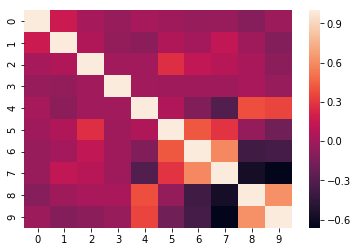

Key:
0 use only to a large house -PRON- , and without ever think how many advantage and accommodation be attach to -PRON- size , -PRON- could be no judge of the privation inevitably belong to a small one .
1 the good lady have not give -PRON- the possibility of escape before . "
2 -PRON- believe -PRON- be one of the very best - temper man that ever exist .
3 -PRON- be a great deal too full of the market to think of any thing else which be just as -PRON- should be , for a thriving man .
4 and , -PRON- dear emma , unless one could be sure of -PRON- make -PRON- into steak , nicely fry , as our be fry , without the small grease , and not roast -PRON- , for no stomach can bear roast pork
5 miss bates have just do as patty open the door ; and -PRON- visitor walk upstairs without have any regular narration to attend to , pursue only by the sound of -PRON- desultory good - will .
6 no , -PRON- dear little modest harriet , depend upon -PRON- the picture will not be in bond - street till just be

In [103]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
# Only taking the first 10 sentences
sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10, 0:10]
# Making a plot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

# Generating a key for the plot
print('Key:')
for i in range(10):
    print(i, sim_matrix.index[i])

In [104]:
terms

['amiable young man',
 'ask pron pron',
 'assure pron pron',
 'away pron pron',
 'bates miss fairfax',
 'begin think pron',
 'believe pron pron',
 'care pron pron',
 'colonel mrs campbell',
 'come pron pron',
 'come say pron',
 'convince pron pron',
 'dare say pron',
 'dare say pron pron',
 'dare say pron shall',
 'day pron pron',
 'dear emma pron',
 'dear harriet pron',
 'dear jane pron',
 'dear madam pron',
 'dear miss woodhouse',
 'dear miss woodhouse pron',
 'dear papa pron',
 'dear say pron',
 'dear sir pron',
 'depend pron pron',
 'emma feel pron',
 'emma know pron',
 'emma pron pron',
 'emma say pron',
 'emma think pron',
 'emma wish pron',
 'far pron pron',
 'feel pron pron',
 'fine young man',
 'forget pron pron',
 'frank churchill come',
 'frank churchill miss',
 'frank churchill pron',
 'good deal pron',
 'good pron pron',
 'great deal better',
 'great deal pron',
 'great pleasure pron',
 'half hour pron',
 'happy pron pron',
 'harriet pron pron',
 'harriet smith pron',
 'he

Changing to lemmas finds different sentences in common.  Some of these make more sense, and some less.  When looking for phrases, changing the n-grams number also changes the groupings. It would also be interesting to see what it is without the pronouns.